# Base solution

In [13]:
from __future__ import annotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from typing import Iterable
import time
import gc

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

from cayleypy import PermutationGroups, CayleyGraph, Predictor, prepare_graph
from tqdm import tqdm


In [2]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
DATA_ROOT = Path('../data')
assert DATA_ROOT.exists(), f'Dataset directory not found: {DATA_ROOT!s}'

TEST_PATH = DATA_ROOT / 'test.csv'
SUBMISSION_PATH = Path('submission.csv')  # Kaggle expects this in the working directory
TEST_PATH

PosixPath('../data/test.csv')

In [5]:
test_df = pd.read_csv(TEST_PATH)

unique_n = sorted(test_df['n'].unique())
print(unique_n)
print(len(unique_n))

[np.int64(5), np.int64(12), np.int64(15), np.int64(16), np.int64(20), np.int64(25), np.int64(30), np.int64(35), np.int64(40), np.int64(45), np.int64(50), np.int64(75), np.int64(100)]
13


## Net

In [6]:
class Net(torch.nn.Module):
    def __init__(self, input_size, num_classes, hidden_dims):
        super().__init__()
        self.num_classes=num_classes

        input_size = input_size * self.num_classes
        layers = []
        for hidden_dim in hidden_dims:
            layers.append(torch.nn.Linear(input_size, hidden_dim))
            layers.append(torch.nn.GELU())
            input_size = hidden_dim
            
        layers.append(torch.nn.Linear(input_size, 1))
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        x = torch.nn.functional.one_hot(x.long(), num_classes=self.num_classes).float().flatten(start_dim=-2)
        return self.layers(x.float()).squeeze(-1)

def train_one_epoch(model, X, y, learning_rate=0.001):
    val_ratio = 0.1
    batch_size = 512 #1024
    dataset = TensorDataset(X, y.float())
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset)-val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    total_train_loss = 0
    
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * xb.size(0)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_val_loss += loss.item() * xb.size(0)

    avg_train_loss = total_train_loss / train_size
    avg_val_loss = total_val_loss / val_size

    return avg_train_loss, avg_val_loss

In [7]:
def train_n(n, width=1000, epochs=30):
    print(f"train for {n} permautations")

    graph=CayleyGraph(PermutationGroups.pancake(n), device="cuda", random_seed=42)
    X, y = graph.random_walks(width=width, length=min(2 * n, 100), mode="bfs")

    input_size = graph.definition.state_size
    #num_classes = int(max(graph.central_state))+1
    num_classes = n

    hidden_dims = [128] #[256]
    learning_rate = 0.001

    train_losses, val_losses = [], []
    start_time = time.time()

    model = Net(input_size, num_classes, hidden_dims).to(graph.device)

    for i in range(epochs):
        avg_train_loss, avg_val_loss = train_one_epoch(model, X, y)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        print(f"Epoch {i} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    end_time = time.time()
    print(end_time - start_time)

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(epochs), y=train_losses, label='Train Loss', marker='o')
    sns.lineplot(x=range(epochs), y=val_losses, label='Val Loss', marker='o')
    plt.title(f'Loss for n={n}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    model = model.cpu()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
    return model, graph

In [8]:
def find_prefix_length(generator_perm):
    n = len(generator_perm)
    for i in range(1, n):
        if generator_perm[i] != generator_perm[i-1] - 1:
            return i 
    
    return n 
    
def convert_to_rk_format(internal_path, graph):
    moves = []
    generators = graph.definition.generators
    
    for move_index in internal_path:
        if 0 <= move_index < len(generators):
            generator_perm = generators[move_index]

            k = find_prefix_length(generator_perm)
            moves.append(f'R{k}')
    
    return moves
   
def solve(permutation, graph, model, heurestic_path, beam_width=10000):
    start_state = np.array(permutation)
    n = len(permutation) 
    result = graph.beam_search(
        start_state=start_state,
        beam_width=beam_width,
        max_steps=3*n,
        predictor=Predictor(graph, model),
        return_path=True
    )
    
    heurestic_length = heurestic_path.count(".") + 1
    if result.path_found and len(result.path) < heurestic_length:
        moves = convert_to_rk_format(result.path, graph)
        return '.'.join(moves)
    else:
        return heurestic_path

## Training

train for 5 permautations
Epoch 0 | Train Loss: 14.2540 | Val Loss: 15.1136
Epoch 1 | Train Loss: 14.0532 | Val Loss: 14.9753
Epoch 2 | Train Loss: 14.1176 | Val Loss: 12.4694
Epoch 3 | Train Loss: 13.7634 | Val Loss: 13.7284
Epoch 4 | Train Loss: 13.5161 | Val Loss: 14.0620
Epoch 5 | Train Loss: 13.6420 | Val Loss: 11.0681
Epoch 6 | Train Loss: 13.2768 | Val Loss: 12.4742
Epoch 7 | Train Loss: 12.9113 | Val Loss: 13.8998
Epoch 8 | Train Loss: 12.8098 | Val Loss: 12.9827
Epoch 9 | Train Loss: 12.5884 | Val Loss: 13.1298
Epoch 10 | Train Loss: 12.0655 | Val Loss: 15.9842
Epoch 11 | Train Loss: 12.5267 | Val Loss: 10.0704
Epoch 12 | Train Loss: 11.9721 | Val Loss: 13.2009
Epoch 13 | Train Loss: 11.9593 | Val Loss: 11.5245
Epoch 14 | Train Loss: 11.7948 | Val Loss: 11.1744
Epoch 15 | Train Loss: 11.3274 | Val Loss: 13.5342
Epoch 16 | Train Loss: 11.4603 | Val Loss: 10.5551
Epoch 17 | Train Loss: 11.2974 | Val Loss: 10.1787
Epoch 18 | Train Loss: 10.9599 | Val Loss: 11.3589
Epoch 19 | Trai

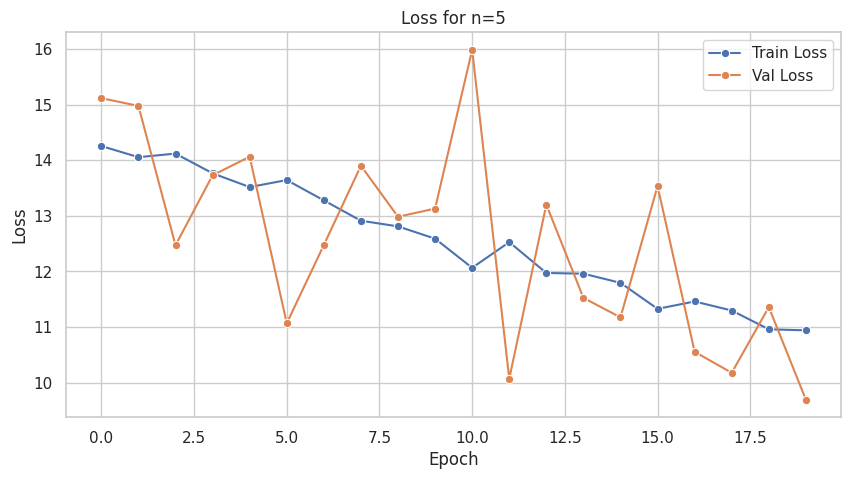

train for 12 permautations
Epoch 0 | Train Loss: 144.3228 | Val Loss: 55.3965
Epoch 1 | Train Loss: 36.2178 | Val Loss: 32.1714
Epoch 2 | Train Loss: 30.6912 | Val Loss: 29.2573
Epoch 3 | Train Loss: 29.3953 | Val Loss: 28.3656
Epoch 4 | Train Loss: 27.8225 | Val Loss: 26.4573
Epoch 5 | Train Loss: 25.5815 | Val Loss: 24.7701
Epoch 6 | Train Loss: 23.3918 | Val Loss: 22.2901
Epoch 7 | Train Loss: 21.6147 | Val Loss: 20.7313
Epoch 8 | Train Loss: 20.2488 | Val Loss: 19.7892
Epoch 9 | Train Loss: 19.1687 | Val Loss: 19.2097
Epoch 10 | Train Loss: 18.4344 | Val Loss: 17.8675
Epoch 11 | Train Loss: 17.7448 | Val Loss: 17.3649
Epoch 12 | Train Loss: 17.1119 | Val Loss: 17.4015
Epoch 13 | Train Loss: 16.6920 | Val Loss: 16.4145
Epoch 14 | Train Loss: 16.2466 | Val Loss: 16.1295
Epoch 15 | Train Loss: 15.8672 | Val Loss: 15.8135
Epoch 16 | Train Loss: 15.5336 | Val Loss: 15.4053
Epoch 17 | Train Loss: 15.2805 | Val Loss: 14.9113
Epoch 18 | Train Loss: 14.9673 | Val Loss: 15.1829
Epoch 19 | Tr

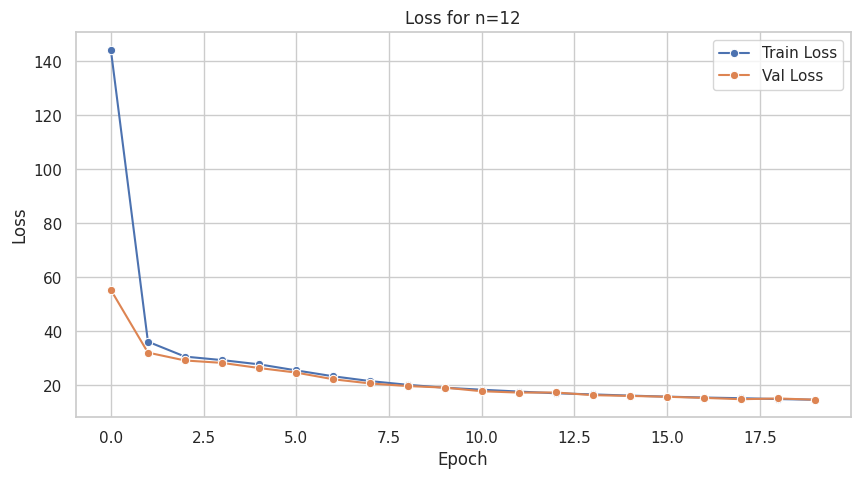

train for 15 permautations
Epoch 0 | Train Loss: 179.2596 | Val Loss: 58.9002
Epoch 1 | Train Loss: 52.1344 | Val Loss: 46.1542
Epoch 2 | Train Loss: 45.2913 | Val Loss: 45.1326
Epoch 3 | Train Loss: 41.4737 | Val Loss: 39.1170
Epoch 4 | Train Loss: 36.3304 | Val Loss: 34.1768
Epoch 5 | Train Loss: 32.0019 | Val Loss: 30.5197
Epoch 6 | Train Loss: 29.1012 | Val Loss: 28.2833
Epoch 7 | Train Loss: 27.1686 | Val Loss: 26.4063
Epoch 8 | Train Loss: 25.6680 | Val Loss: 25.4022
Epoch 9 | Train Loss: 24.5687 | Val Loss: 24.0171
Epoch 10 | Train Loss: 23.6045 | Val Loss: 22.6315
Epoch 11 | Train Loss: 22.7219 | Val Loss: 22.1079
Epoch 12 | Train Loss: 21.9312 | Val Loss: 21.3598
Epoch 13 | Train Loss: 21.1611 | Val Loss: 21.1179
Epoch 14 | Train Loss: 20.4618 | Val Loss: 20.4401
Epoch 15 | Train Loss: 19.8328 | Val Loss: 19.6005
Epoch 16 | Train Loss: 19.2273 | Val Loss: 18.9227
Epoch 17 | Train Loss: 18.6322 | Val Loss: 19.1896
Epoch 18 | Train Loss: 18.1280 | Val Loss: 18.4261
Epoch 19 | Tr

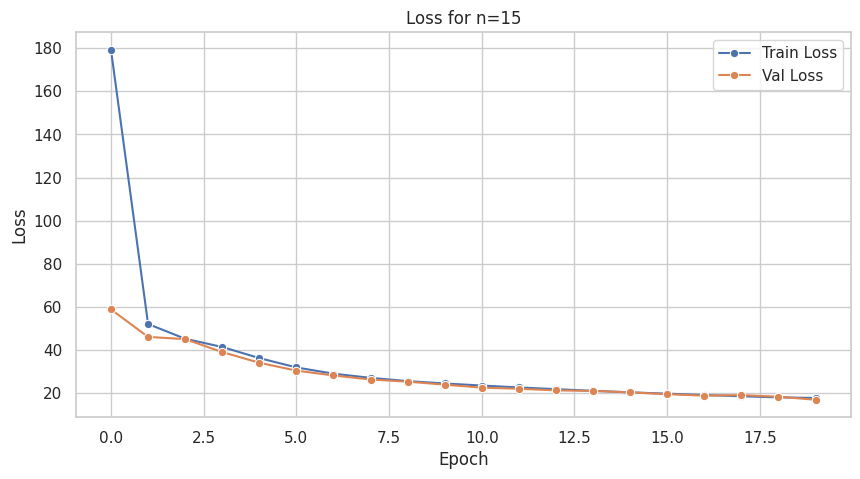

train for 16 permautations
Epoch 0 | Train Loss: 195.4998 | Val Loss: 67.4816
Epoch 1 | Train Loss: 59.1599 | Val Loss: 55.7493
Epoch 2 | Train Loss: 52.9452 | Val Loss: 49.5782
Epoch 3 | Train Loss: 47.8262 | Val Loss: 45.0585
Epoch 4 | Train Loss: 42.0674 | Val Loss: 39.1533
Epoch 5 | Train Loss: 37.4282 | Val Loss: 35.5509
Epoch 6 | Train Loss: 34.2100 | Val Loss: 32.9485
Epoch 7 | Train Loss: 31.9364 | Val Loss: 30.9696
Epoch 8 | Train Loss: 30.1427 | Val Loss: 29.7955
Epoch 9 | Train Loss: 28.6459 | Val Loss: 28.6084
Epoch 10 | Train Loss: 27.5139 | Val Loss: 26.3257
Epoch 11 | Train Loss: 26.2735 | Val Loss: 26.6051
Epoch 12 | Train Loss: 25.4066 | Val Loss: 24.5819
Epoch 13 | Train Loss: 24.4143 | Val Loss: 24.2977
Epoch 14 | Train Loss: 23.5349 | Val Loss: 23.3120
Epoch 15 | Train Loss: 22.7817 | Val Loss: 22.3299
Epoch 16 | Train Loss: 22.0343 | Val Loss: 21.9978
Epoch 17 | Train Loss: 21.3513 | Val Loss: 21.5212
Epoch 18 | Train Loss: 20.7060 | Val Loss: 20.9909
Epoch 19 | Tr

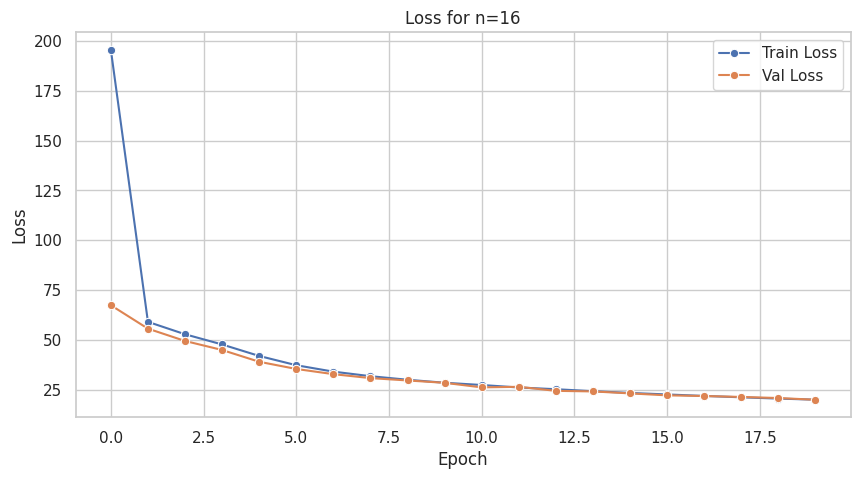

train for 20 permautations
Epoch 0 | Train Loss: 259.5668 | Val Loss: 102.6923
Epoch 1 | Train Loss: 89.1250 | Val Loss: 81.6037
Epoch 2 | Train Loss: 77.5770 | Val Loss: 71.9745
Epoch 3 | Train Loss: 66.9729 | Val Loss: 62.2860
Epoch 4 | Train Loss: 56.6576 | Val Loss: 53.5099
Epoch 5 | Train Loss: 49.4312 | Val Loss: 46.6382
Epoch 6 | Train Loss: 44.3467 | Val Loss: 41.5978
Epoch 7 | Train Loss: 40.2550 | Val Loss: 40.3591
Epoch 8 | Train Loss: 37.3508 | Val Loss: 36.0055
Epoch 9 | Train Loss: 34.6911 | Val Loss: 34.2208
Epoch 10 | Train Loss: 32.7010 | Val Loss: 31.3811
Epoch 11 | Train Loss: 30.8209 | Val Loss: 29.4391
Epoch 12 | Train Loss: 29.0596 | Val Loss: 29.0063
Epoch 13 | Train Loss: 27.6437 | Val Loss: 27.3495
Epoch 14 | Train Loss: 26.3644 | Val Loss: 26.4435
Epoch 15 | Train Loss: 25.2830 | Val Loss: 25.1622
Epoch 16 | Train Loss: 24.2593 | Val Loss: 24.0093
Epoch 17 | Train Loss: 23.3213 | Val Loss: 22.9116
Epoch 18 | Train Loss: 22.4771 | Val Loss: 22.0233
Epoch 19 | T

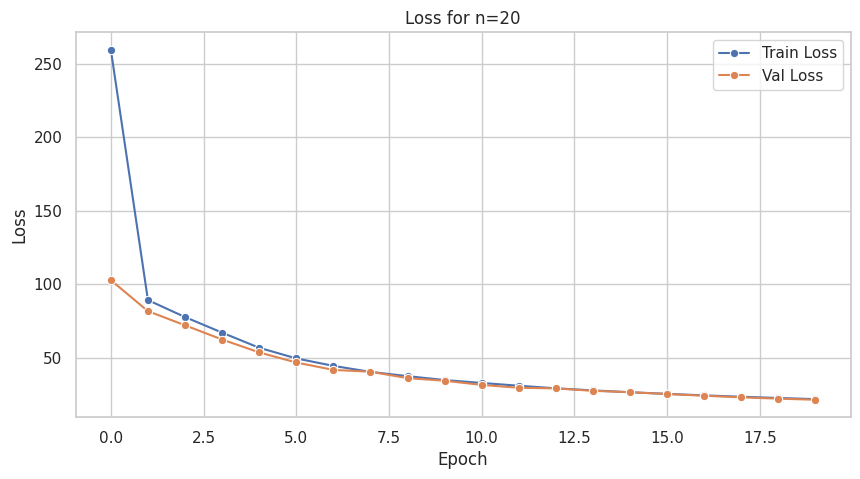

train for 25 permautations
Epoch 0 | Train Loss: 337.8613 | Val Loss: 151.8175
Epoch 1 | Train Loss: 137.5963 | Val Loss: 126.1590
Epoch 2 | Train Loss: 117.7034 | Val Loss: 104.2286
Epoch 3 | Train Loss: 96.2091 | Val Loss: 89.1602
Epoch 4 | Train Loss: 81.1989 | Val Loss: 76.4951
Epoch 5 | Train Loss: 70.7025 | Val Loss: 67.4791
Epoch 6 | Train Loss: 63.0993 | Val Loss: 60.1719
Epoch 7 | Train Loss: 57.2858 | Val Loss: 55.0479
Epoch 8 | Train Loss: 52.5509 | Val Loss: 51.4553
Epoch 9 | Train Loss: 48.7247 | Val Loss: 47.2742
Epoch 10 | Train Loss: 45.4169 | Val Loss: 44.0963
Epoch 11 | Train Loss: 42.4530 | Val Loss: 41.5272
Epoch 12 | Train Loss: 39.7504 | Val Loss: 40.3926
Epoch 13 | Train Loss: 37.6402 | Val Loss: 37.1135
Epoch 14 | Train Loss: 35.5344 | Val Loss: 36.0018
Epoch 15 | Train Loss: 33.9340 | Val Loss: 32.5246
Epoch 16 | Train Loss: 32.1708 | Val Loss: 32.2454
Epoch 17 | Train Loss: 30.7665 | Val Loss: 30.5453
Epoch 18 | Train Loss: 29.3880 | Val Loss: 29.5074
Epoch 19

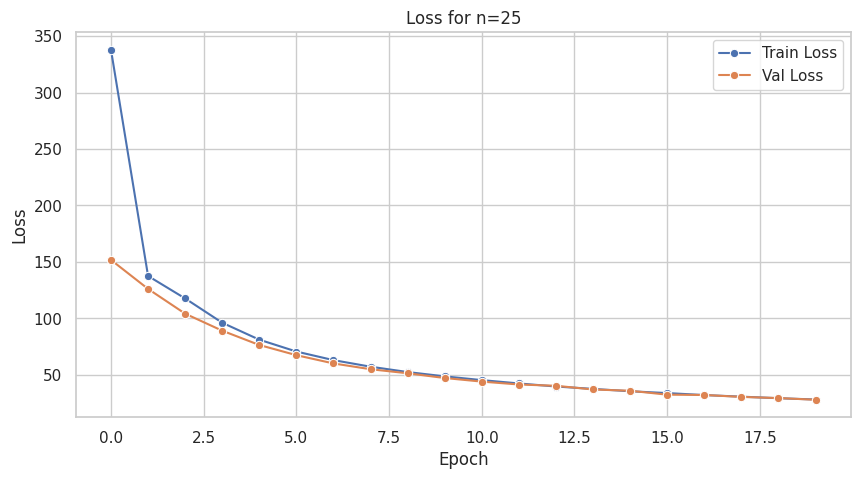

train for 30 permautations
Epoch 0 | Train Loss: 456.7629 | Val Loss: 205.7365
Epoch 1 | Train Loss: 186.4178 | Val Loss: 177.9670
Epoch 2 | Train Loss: 164.8718 | Val Loss: 151.4307
Epoch 3 | Train Loss: 135.6134 | Val Loss: 124.8391
Epoch 4 | Train Loss: 110.7375 | Val Loss: 102.3706
Epoch 5 | Train Loss: 92.9941 | Val Loss: 85.8921
Epoch 6 | Train Loss: 80.0416 | Val Loss: 78.2849
Epoch 7 | Train Loss: 70.7841 | Val Loss: 67.9183
Epoch 8 | Train Loss: 63.1586 | Val Loss: 59.1695
Epoch 9 | Train Loss: 56.5340 | Val Loss: 53.6619
Epoch 10 | Train Loss: 51.1389 | Val Loss: 49.0331
Epoch 11 | Train Loss: 46.5103 | Val Loss: 45.9634
Epoch 12 | Train Loss: 42.6196 | Val Loss: 42.7018
Epoch 13 | Train Loss: 39.4242 | Val Loss: 38.8173
Epoch 14 | Train Loss: 36.5647 | Val Loss: 35.8150
Epoch 15 | Train Loss: 34.0123 | Val Loss: 33.9396
Epoch 16 | Train Loss: 31.8615 | Val Loss: 32.0056
Epoch 17 | Train Loss: 30.0378 | Val Loss: 29.6818
Epoch 18 | Train Loss: 28.2353 | Val Loss: 28.6708
Epoc

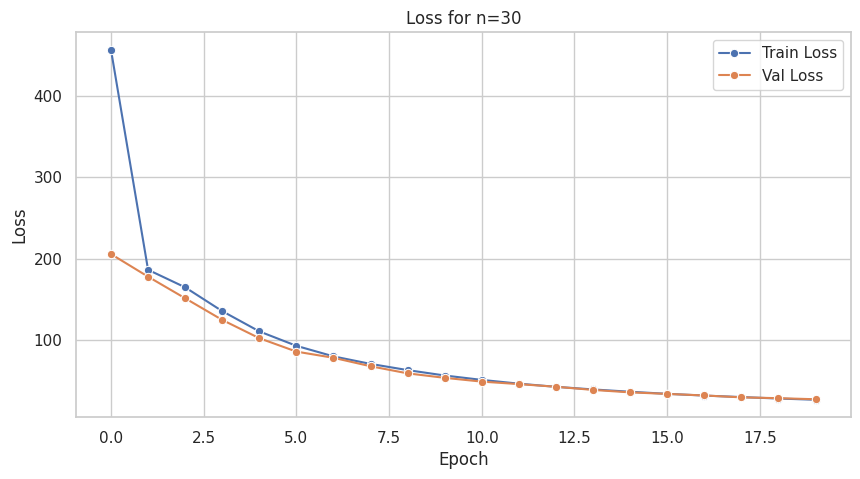

train for 35 permautations
Epoch 0 | Train Loss: 571.7782 | Val Loss: 273.8813
Epoch 1 | Train Loss: 247.8922 | Val Loss: 229.0566
Epoch 2 | Train Loss: 209.5175 | Val Loss: 188.3397
Epoch 3 | Train Loss: 168.6522 | Val Loss: 149.4458
Epoch 4 | Train Loss: 138.0121 | Val Loss: 128.3035
Epoch 5 | Train Loss: 116.1191 | Val Loss: 109.4290
Epoch 6 | Train Loss: 99.4641 | Val Loss: 92.2427
Epoch 7 | Train Loss: 85.8257 | Val Loss: 82.0068
Epoch 8 | Train Loss: 74.9650 | Val Loss: 72.6857
Epoch 9 | Train Loss: 66.4397 | Val Loss: 63.5747
Epoch 10 | Train Loss: 59.1961 | Val Loss: 58.5859
Epoch 11 | Train Loss: 53.4070 | Val Loss: 53.1612
Epoch 12 | Train Loss: 48.4896 | Val Loss: 49.2454
Epoch 13 | Train Loss: 44.5362 | Val Loss: 43.7822
Epoch 14 | Train Loss: 40.8981 | Val Loss: 41.1284
Epoch 15 | Train Loss: 37.8370 | Val Loss: 37.8720
Epoch 16 | Train Loss: 35.2391 | Val Loss: 34.5579
Epoch 17 | Train Loss: 32.8379 | Val Loss: 33.3850
Epoch 18 | Train Loss: 30.9358 | Val Loss: 30.2781
Ep

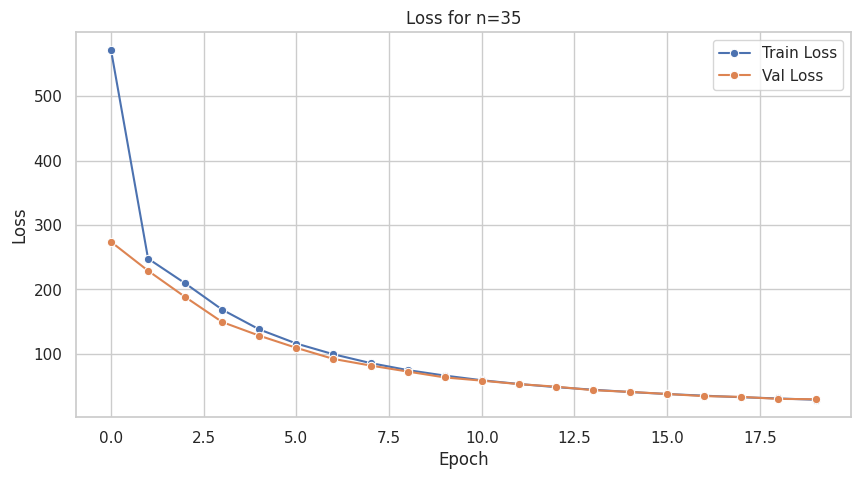

train for 40 permautations
Epoch 0 | Train Loss: 676.9947 | Val Loss: 334.6836
Epoch 1 | Train Loss: 312.0911 | Val Loss: 299.9495
Epoch 2 | Train Loss: 280.3042 | Val Loss: 259.8724
Epoch 3 | Train Loss: 236.0080 | Val Loss: 216.9348
Epoch 4 | Train Loss: 196.3003 | Val Loss: 179.3643
Epoch 5 | Train Loss: 165.3757 | Val Loss: 153.6801
Epoch 6 | Train Loss: 141.4522 | Val Loss: 136.1347
Epoch 7 | Train Loss: 123.5262 | Val Loss: 115.7720
Epoch 8 | Train Loss: 108.4112 | Val Loss: 105.4859
Epoch 9 | Train Loss: 96.0238 | Val Loss: 94.3734
Epoch 10 | Train Loss: 85.9422 | Val Loss: 82.8702
Epoch 11 | Train Loss: 77.5013 | Val Loss: 74.4775
Epoch 12 | Train Loss: 70.2449 | Val Loss: 67.7102
Epoch 13 | Train Loss: 63.9189 | Val Loss: 63.3655
Epoch 14 | Train Loss: 58.7217 | Val Loss: 57.6158
Epoch 15 | Train Loss: 53.9609 | Val Loss: 54.1375
Epoch 16 | Train Loss: 50.0060 | Val Loss: 49.8789
Epoch 17 | Train Loss: 46.4845 | Val Loss: 47.0533
Epoch 18 | Train Loss: 43.4253 | Val Loss: 44.6

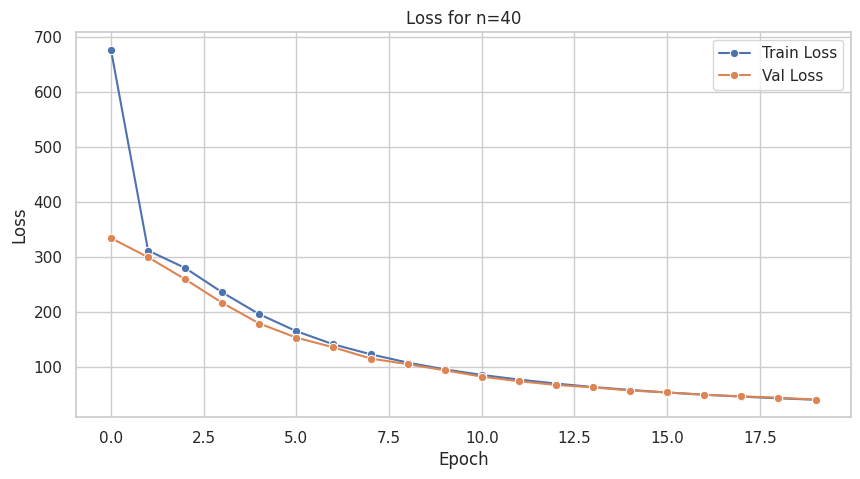

train for 45 permautations
Epoch 0 | Train Loss: 822.0250 | Val Loss: 406.6670
Epoch 1 | Train Loss: 368.5259 | Val Loss: 356.2822
Epoch 2 | Train Loss: 324.3381 | Val Loss: 294.9261
Epoch 3 | Train Loss: 258.6399 | Val Loss: 227.6945
Epoch 4 | Train Loss: 204.1892 | Val Loss: 187.7446
Epoch 5 | Train Loss: 165.6671 | Val Loss: 155.5879
Epoch 6 | Train Loss: 137.5560 | Val Loss: 128.3067
Epoch 7 | Train Loss: 115.9908 | Val Loss: 109.1099
Epoch 8 | Train Loss: 99.5820 | Val Loss: 95.3431
Epoch 9 | Train Loss: 86.9410 | Val Loss: 83.7410
Epoch 10 | Train Loss: 77.2673 | Val Loss: 72.4416
Epoch 11 | Train Loss: 69.0015 | Val Loss: 67.5865
Epoch 12 | Train Loss: 62.5175 | Val Loss: 61.8621
Epoch 13 | Train Loss: 57.2192 | Val Loss: 56.3728
Epoch 14 | Train Loss: 52.7512 | Val Loss: 52.7283
Epoch 15 | Train Loss: 48.9187 | Val Loss: 48.8108
Epoch 16 | Train Loss: 45.6349 | Val Loss: 46.3888
Epoch 17 | Train Loss: 42.9143 | Val Loss: 43.2799
Epoch 18 | Train Loss: 40.3684 | Val Loss: 41.317

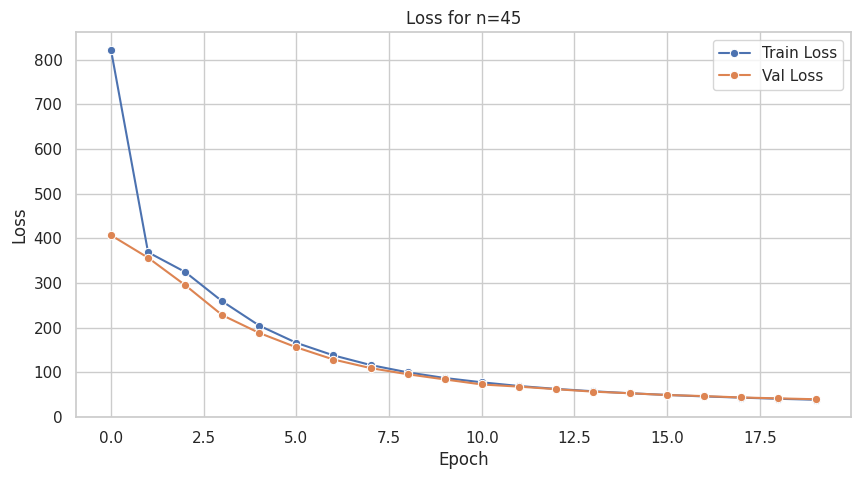

train for 50 permautations
Epoch 0 | Train Loss: 969.6804 | Val Loss: 470.3374
Epoch 1 | Train Loss: 431.9474 | Val Loss: 400.5169
Epoch 2 | Train Loss: 383.7960 | Val Loss: 355.4138
Epoch 3 | Train Loss: 328.7862 | Val Loss: 296.1891
Epoch 4 | Train Loss: 263.3232 | Val Loss: 235.7775
Epoch 5 | Train Loss: 203.5966 | Val Loss: 182.8836
Epoch 6 | Train Loss: 159.8207 | Val Loss: 144.5219
Epoch 7 | Train Loss: 129.3490 | Val Loss: 122.2801
Epoch 8 | Train Loss: 107.8247 | Val Loss: 101.9633
Epoch 9 | Train Loss: 91.7722 | Val Loss: 88.7801
Epoch 10 | Train Loss: 79.8271 | Val Loss: 77.6930
Epoch 11 | Train Loss: 70.3934 | Val Loss: 68.8428
Epoch 12 | Train Loss: 62.8947 | Val Loss: 63.3115
Epoch 13 | Train Loss: 57.0525 | Val Loss: 57.3164
Epoch 14 | Train Loss: 52.0383 | Val Loss: 52.8839
Epoch 15 | Train Loss: 48.1126 | Val Loss: 48.8962
Epoch 16 | Train Loss: 44.6963 | Val Loss: 44.9978
Epoch 17 | Train Loss: 41.5944 | Val Loss: 44.1345
Epoch 18 | Train Loss: 39.2363 | Val Loss: 40.5

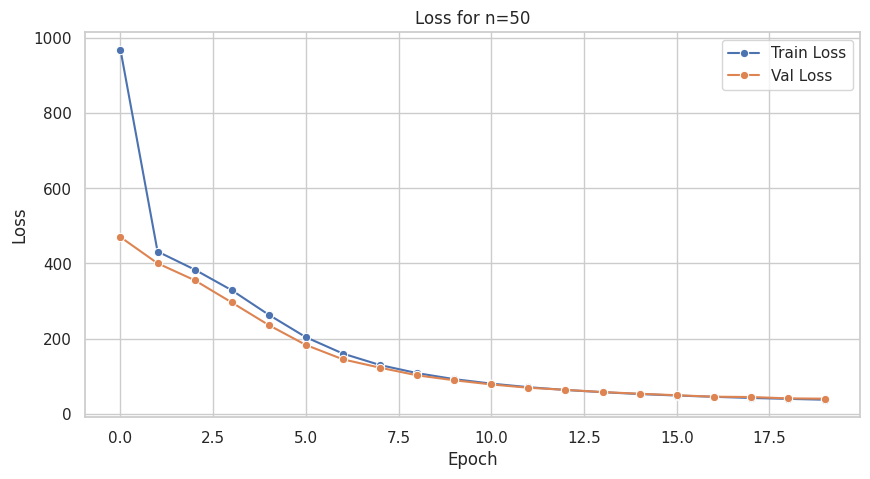

train for 75 permautations
Epoch 0 | Train Loss: 853.4557 | Val Loss: 439.4503
Epoch 1 | Train Loss: 382.9783 | Val Loss: 356.6406
Epoch 2 | Train Loss: 327.4618 | Val Loss: 312.8338
Epoch 3 | Train Loss: 286.7275 | Val Loss: 271.7663
Epoch 4 | Train Loss: 244.9086 | Val Loss: 228.7753
Epoch 5 | Train Loss: 196.9776 | Val Loss: 177.5878
Epoch 6 | Train Loss: 148.8261 | Val Loss: 137.3327
Epoch 7 | Train Loss: 111.5157 | Val Loss: 102.1617
Epoch 8 | Train Loss: 84.8110 | Val Loss: 81.3222
Epoch 9 | Train Loss: 66.4147 | Val Loss: 63.4328
Epoch 10 | Train Loss: 53.3168 | Val Loss: 51.2940
Epoch 11 | Train Loss: 43.6135 | Val Loss: 44.1432
Epoch 12 | Train Loss: 36.5435 | Val Loss: 37.0444
Epoch 13 | Train Loss: 30.9206 | Val Loss: 32.8618
Epoch 14 | Train Loss: 26.7581 | Val Loss: 27.8412
Epoch 15 | Train Loss: 23.2609 | Val Loss: 24.9234
Epoch 16 | Train Loss: 20.5174 | Val Loss: 21.9408
Epoch 17 | Train Loss: 18.2303 | Val Loss: 19.5337
Epoch 18 | Train Loss: 16.3887 | Val Loss: 18.210

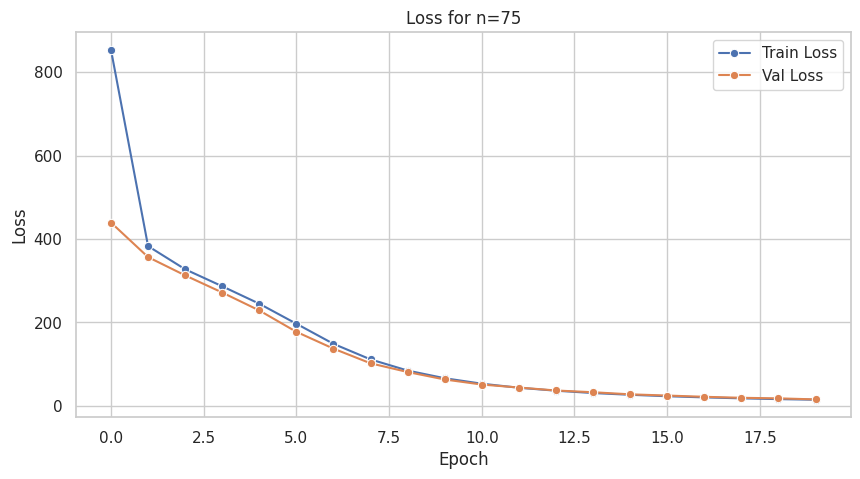

train for 100 permautations
Epoch 0 | Train Loss: 813.6884 | Val Loss: 363.0275
Epoch 1 | Train Loss: 305.0512 | Val Loss: 267.7527
Epoch 2 | Train Loss: 235.2692 | Val Loss: 218.7940
Epoch 3 | Train Loss: 191.3699 | Val Loss: 175.1122
Epoch 4 | Train Loss: 147.0707 | Val Loss: 128.2746
Epoch 5 | Train Loss: 101.3318 | Val Loss: 89.7040
Epoch 6 | Train Loss: 67.7307 | Val Loss: 61.9394
Epoch 7 | Train Loss: 46.5377 | Val Loss: 45.5732
Epoch 8 | Train Loss: 33.5630 | Val Loss: 31.5504
Epoch 9 | Train Loss: 24.7290 | Val Loss: 25.7975
Epoch 10 | Train Loss: 18.9003 | Val Loss: 19.5811
Epoch 11 | Train Loss: 14.9900 | Val Loss: 16.2523
Epoch 12 | Train Loss: 12.2537 | Val Loss: 13.1261
Epoch 13 | Train Loss: 10.1909 | Val Loss: 10.9553
Epoch 14 | Train Loss: 8.7479 | Val Loss: 9.7347
Epoch 15 | Train Loss: 7.6425 | Val Loss: 8.4883
Epoch 16 | Train Loss: 6.8657 | Val Loss: 7.5370
Epoch 17 | Train Loss: 6.2231 | Val Loss: 6.7931
Epoch 18 | Train Loss: 5.6961 | Val Loss: 6.3458
Epoch 19 | T

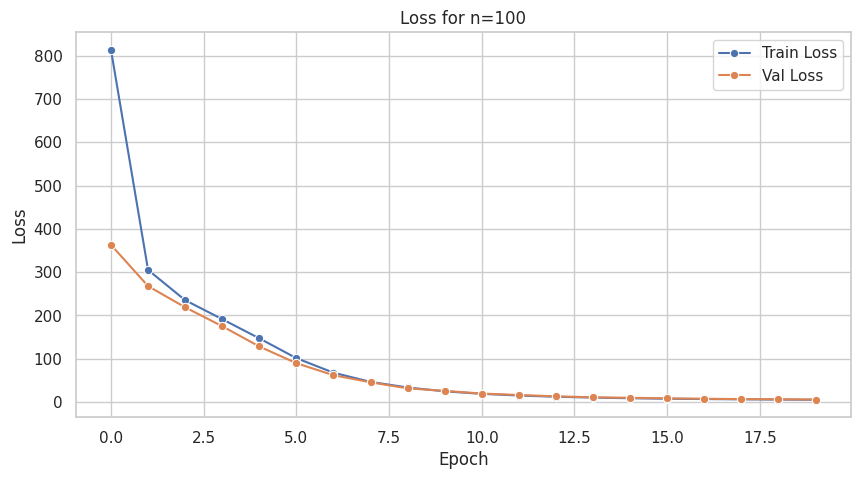

Total Timr: 230.7320055961609


In [9]:
models_dict = {}
graphs_dict = {}

start_time = time.time()

for n in unique_n:
    model, graph = train_n(n, width=2000, epochs=20)
    models_dict[n] = model
    graphs_dict[n] = graph

    end_time = time.time()

print(f"Total Timr: {end_time - start_time}")

In [10]:
def pancake_sort_path(perm: list[int]) -> list[str]:
    """Return a sequence of prefix reversals that sorts `perm` to the identity permutation."""
    arr = list(perm)
    n = len(arr)
    moves: list[str] = []

    for target in range(n, 1, -1):
        desired_value = target - 1
        idx = arr.index(desired_value)

        if idx == target - 1:
            continue  # already in place

        if idx != 0:
            moves.append(f'R{idx + 1}')
            arr[: idx + 1] = reversed(arr[: idx + 1])

        moves.append(f'R{target}')
        arr[:target] = reversed(arr[:target])

    return moves

In [11]:
heurestic_paths = []
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    perms = np.array(row["permutation"].split(",")).astype(int)
    moves = pancake_sort_path(perms)
    heurestic_paths.append(".".join(moves))

100%|██████████| 2405/2405 [00:00<00:00, 8710.34it/s] 


# Infer

In [ ]:
import numpy as np

submission_rows: list[dict[str, str]] = []

start_time = time.time()

for i, row in tqdm(enumerate(test_df.itertuples(index=False)), total=len(test_df)):
    try:
        perm = [int(x) for x in row.permutation.split(',')]
        n = len(perm)
        #print(f"{idx}. Infer model for {n}")
        model = models_dict[n]   
        graph = graphs_dict[n] 
        graph.free_memory()
        solution = solve(perm, graph, model, heurestic_paths[i], beam_width=1000)
        submission_rows.append({
            'id': row.id, 
            'permutation': n, 
            'solution': solution
        })

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        
    except (torch.cuda.OutOfMemoryError, RuntimeError) as e:
        print(f"OutOfMemoryError at index {i}, filling ALL remaining rows with heuristic paths")

        submission_rows.append({'id': row.id, 'permutation': n, 'solution': heurestic_paths[i]})
        
        for j in range(i + 1, len(test_df)):
            remaining_row = test_df.iloc[j]
            remaining_perm = [int(x) for x in remaining_row.permutation.split(',')]
            remaining_n = len(remaining_perm)
            submission_rows.append({
                'id': remaining_row.id, 
                'permutation': remaining_n, 
                'solution': heurestic_paths[j]
            })
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

end_time = time.time()
print(f"Total Timr: {end_time - start_time}")

 92%|█████████▏| 2205/2405 [4:11:31<22:48,  6.84s/it]  


OutOfMemoryError: CUDA out of memory. Tried to allocate 7.31 GiB. GPU 0 has a total capacity of 7.77 GiB of which 5.68 GiB is free. Including non-PyTorch memory, this process has 1.33 GiB memory in use. Of the allocated memory 506.11 MiB is allocated by PyTorch, and 679.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [14]:
submission_df = pd.DataFrame(submission_rows).sort_values('id').reset_index(drop=True)
submission_df.head()

submission_df.to_csv("dummy_sub.csv")